In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


tf.random.set_seed(42)
np.random.seed(42)

2025-09-08 10:54:59.526144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757328899.911773      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757328900.016774      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = '/kaggle/input/breast-ultrasound-images-dataset'
images_path = os.path.join(dataset_path, 'Dataset_BUSI_with_GT')

In [6]:
images = []
masks = []

for img_path, mask_path in zip(image_paths, mask_paths):
    image, mask = load_data(img_path, mask_path)
    if image is not None and mask is not None:
        images.append(image)
        masks.append(mask)

images = np.array(images)
masks = np.array(masks)

print(f"Loaded {len(images)} images and {len(masks)} masks")
print(f"Images shape: {images.shape}, Masks shape: {masks.shape}")


Loaded 780 images and 780 masks
Images shape: (780, 256, 256, 1), Masks shape: (780, 256, 256, 1)


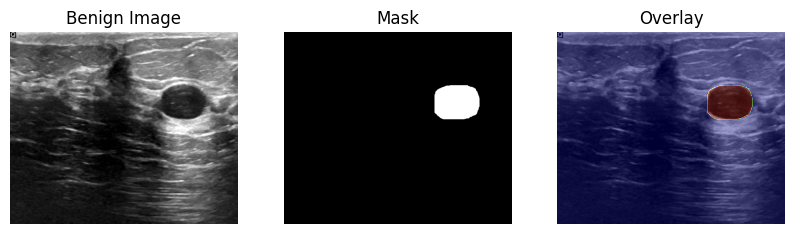

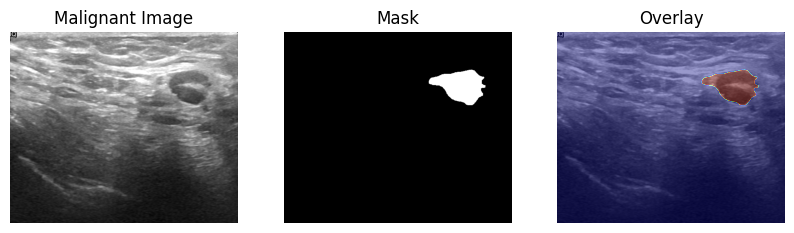

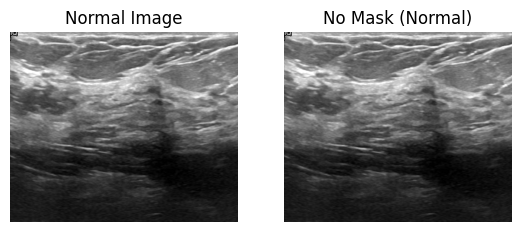

In [6]:
def show_sample(image_dir, title, with_mask=True):
    
    files = [f for f in os.listdir(image_dir) if ("mask" not in f and f.endswith(".png"))]
    img_file = random.choice(files)
    
    
    img_path = os.path.join(image_dir, img_file)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.imshow(image, cmap="gray")
    plt.title(f"{title} Image")
    plt.axis("off")
    
    if with_mask:
        # mask file has "_mask" added before .png
        base_name = img_file.replace(".png", "")
        mask_file = base_name + "_mask.png"
        mask_path = os.path.join(image_dir, mask_file)

        # load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        plt.subplot(1,3,2)
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(image, cmap="gray")
        plt.imshow(mask, cmap="jet", alpha=0.4)
        plt.title("Overlay")
        plt.axis("off")
    else:
        plt.subplot(1,3,2)
        plt.imshow(image, cmap="gray")
        plt.title("No Mask (Normal)")
        plt.axis("off")
    
    plt.show()


show_sample(os.path.join(images_path, "benign"), "Benign", with_mask=True)
show_sample(os.path.join(images_path, "malignant"), "Malignant", with_mask=True)
show_sample(os.path.join(images_path, "normal"), "Normal", with_mask=False)

In [26]:
from sklearn.model_selection import train_test_split
import tensorflow as tf


def load_busi_images(image_dir, target_size=(128, 128)):
    imgs, masks = [], []
    all_files = [f for f in os.listdir(image_dir) if f.endswith(".png") and "mask" not in f]

    for f in all_files:
        img_path = os.path.join(image_dir, f)
        mask_path = os.path.join(image_dir, f.replace(".png", "_mask.png"))

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is not None and mask is not None:
            img = cv2.resize(img, target_size)
            mask = cv2.resize(mask, target_size)

            imgs.append(img)
            masks.append(mask)

    return np.array(imgs), np.array(masks)



benign_imgs, benign_masks = load_busi_images(os.path.join(images_path, "benign"))
malignant_imgs, malignant_masks = load_busi_images(os.path.join(images_path, "malignant"))

X = np.concatenate([benign_imgs, malignant_imgs], axis=0)
y = np.concatenate([benign_masks, malignant_masks], axis=0)

print("Raw shapes:", X.shape, y.shape)  (647, 128, 128)

Raw shapes: (647, 128, 128) (647, 128, 128)


In [27]:
X = X.astype("float32") / 255.0
y = (y > 0).astype("float32") 

In [28]:
X = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)

print("Processed shapes:", X.shape, y.shape)


Processed shapes: (647, 128, 128, 1) (647, 128, 128, 1)


In [29]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape)

Train: (582, 128, 128, 1) Val: (65, 128, 128, 1)


In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt


def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)
    return img, mask


train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(500)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(8)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(8)
    .prefetch(tf.data.AUTOTUNE)
)


In [41]:
def conv_block(x, filters, kernel_size=3, batch_norm=True):
    for _ in range(2):
        x = tf.keras.layers.Conv2D(filters, (kernel_size, kernel_size),
                                   padding="same",
                                   kernel_initializer="he_normal")(x)
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
    return x

def encoder_step(x, filters, dropout=0.1, batch_norm=True):
    conv = conv_block(x, filters, batch_norm=batch_norm)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
    pool = tf.keras.layers.Dropout(dropout)(pool)
    return conv, pool

def decoder_step(x, skip, filters, dropout=0.1, batch_norm=True):
    up = tf.keras.layers.Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding="same")(x)
    merge = tf.keras.layers.Concatenate()([up, skip])
    merge = tf.keras.layers.Dropout(dropout)(merge)
    conv = conv_block(merge, filters, batch_norm=batch_norm)
    return conv

def build_unet(input_shape=(128, 128, 1), start_filters=16, dropout=0.1, batch_norm=True):
    inputs = tf.keras.layers.Input(input_shape)

    # Encode
    e1, p1 = encoder_step(inputs, start_filters * 1, dropout, batch_norm)
    e2, p2 = encoder_step(p1, start_filters * 2, dropout, batch_norm)
    e3, p3 = encoder_step(p2, start_filters * 4, dropout, batch_norm)
    e4, p4 = encoder_step(p3, start_filters * 8, dropout, batch_norm)

    # Bottleneck
    b = conv_block(p4, start_filters * 16, batch_norm=batch_norm)

    # Decoder
    d1 = decoder_step(b, e4, start_filters * 8, dropout, batch_norm)
    d2 = decoder_step(d1, e3, start_filters * 4, dropout, batch_norm)
    d3 = decoder_step(d2, e2, start_filters * 2, dropout, batch_norm)
    d4 = decoder_step(d3, e1, start_filters * 1, dropout, batch_norm)

    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(d4)

    return tf.keras.Model(inputs=[inputs], outputs=[outputs], name="CustomU-Net")


In [44]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

In [45]:
model = build_unet(input_shape=(128, 128, 1))
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=dice_loss,
    metrics=["accuracy", dice_coef]
)


callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_unet.h5", save_best_only=True, monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
]


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_152']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


73/73 ━━━━━━━━━━━━━━━━━━━━ 56s 290ms/step - accuracy: 0.5757 - dice_coef: 0.1663 - loss: 0.8337 - val_accuracy: 0.9032 - val_dice_coef: 0.1498 - val_loss: 0.8388 - learning_rate: 1.0000e-04
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8055 - dice_coef: 0.2633 - loss: 0.7367 - val_accuracy: 0.9157 - val_dice_coef: 0.2105 - val_loss: 0.7738 - learning_rate: 1.0000e-04
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8138 - dice_coef: 0.2934 - loss: 0.7066 - val_accuracy: 0.8854 - val_dice_coef: 0.2656 - val_loss: 0.7149 - learning_rate: 1.0000e-04
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8365 - dice_coef: 0.3493 - loss: 0.6507 - val_accuracy: 0.9318 - val_dice_coef: 0.3065 - val_loss: 0.6708 - learning_rate: 1.0000e-04
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8441 - dice_coef: 0.3326 - loss: 0.6674 - val_accuracy: 0.8761 - val_dice_coef: 0.3187 - val_loss: 0.6596 - learning_rate: 1.0000e-04
Epoch 6/50
73/

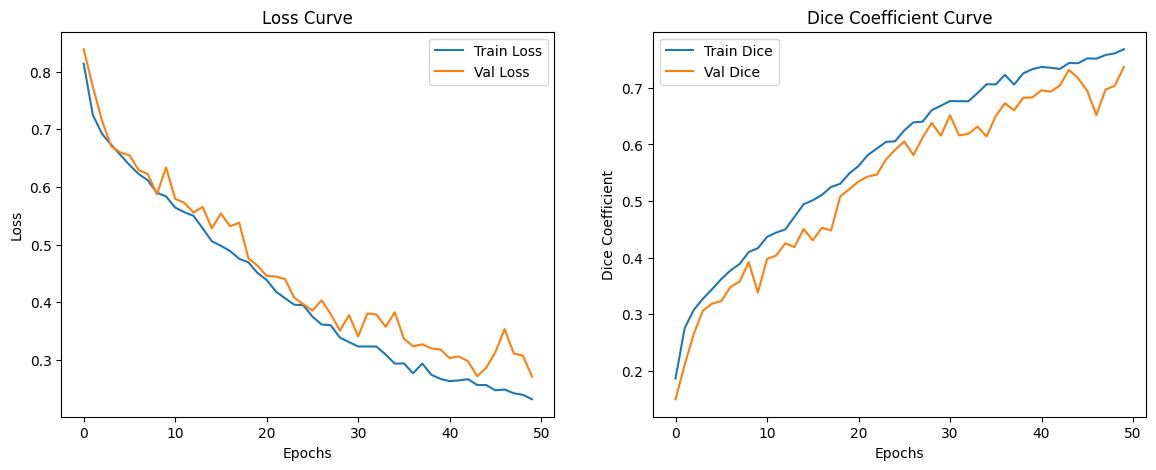

In [46]:
def plot_history(history):
    plt.figure(figsize=(14, 5))

    # 🔹 Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # 🔹 Dice Coefficient
    plt.subplot(1, 2, 2)
    plt.plot(history.history["dice_coef"], label="Train Dice")
    plt.plot(history.history["val_dice_coef"], label="Val Dice")
    plt.title("Dice Coefficient Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coefficient")
    plt.legend()

    plt.show()


plot_history(history)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_152']
Received: inputs=Tensor(shape=(8, 128, 128, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


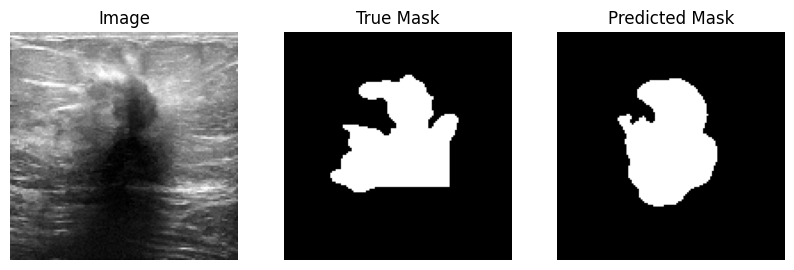

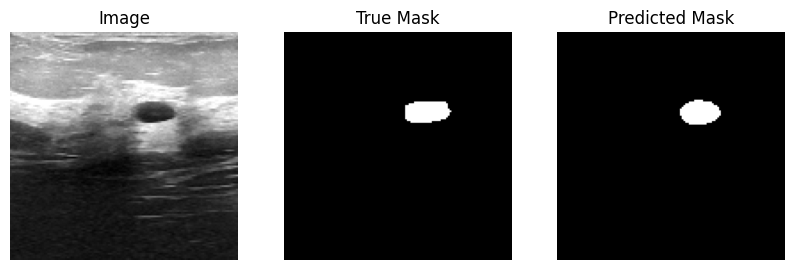

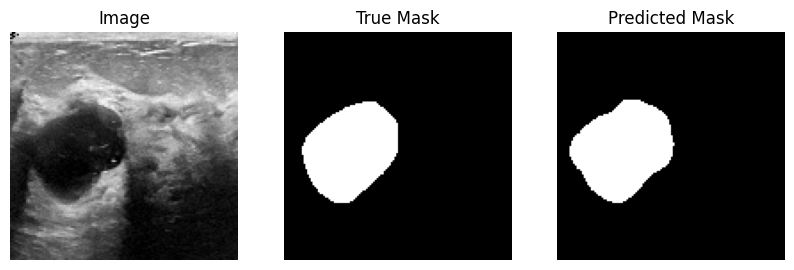

In [47]:
def show_predictions(model, dataset, num=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        for i in range(num):
            plt.figure(figsize=(10,4))

            plt.subplot(1,3,1)
            plt.title("Image")
            plt.imshow(images[i].numpy().squeeze(), cmap="gray")
            plt.axis("off")

            plt.subplot(1,3,2)
            plt.title("True Mask")
            plt.imshow(masks[i].numpy().squeeze(), cmap="gray")
            plt.axis("off")

            plt.subplot(1,3,3)
            plt.title("Predicted Mask")
            plt.imshow(preds[i].squeeze() > 0.5, cmap="gray")
            plt.axis("off")

            plt.show()


show_predictions(model, val_dataset)